In [1]:
## import warnings
import time
import math
import os
import glob
from pyhere import here
from datetime import date
import re

import numpy as np
import pandas as pd
import geopandas
import pickle

import pyarrow
import itertools
import multiprocessing
import p_tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split, KFold, LeaveOneGroupOut, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.metrics import r2_score
from scipy.stats import spearmanr,  pearsonr

In [2]:
def str2bool(string):
    return string.lower() in ("yes", "true", "t", "1")

point_pattern = re.compile("20k-points")
wa_pattern = re.compile("cm-False")

In [3]:
data_dir = here("data")
directory = here("data", "random_features", "summary")
files = os.listdir(directory)
files = [f for f in files if f not in ('.gitkeep', '.ipynb_checkpoints')]
files = [f for f in files if not (bool(point_pattern.search(f)) & bool(wa_pattern.search(f)))]
len(files)

44

In [4]:
paramlist = list(itertools.product(files, [True, False]))
len(paramlist)

88

In [13]:
def model(params):
#########################################     SET PARAMS    #########################################
    file         = params[0]
    hot_encode   = params[1]
    f            = file.split(sep="_")
    satellite    = f[0]
    bands        = f[1].replace("bands-", "")
    country_code = f[2]
    points       = f[3].replace("k-points", "")
    num_features = f[4].replace("-features", "")
    yrs          = f[5].replace("yr-", "").split(sep="-")
    mns          = f[6].replace("mn-", "").split(sep="-")
    limit_months = str2bool(f[7].replace("lm-", ""))
    crop_mask    = str2bool(f[8].replace("cm-", ""))
    weighted_avg = str2bool(f[9].replace("wa-", ""))
    years        = range(int(yrs[0]), int(yrs[1])+1)
    month_range  = list(range(int(mns[0]), int(mns[1])+1))
    
#########################################     READ DATA    #########################################
    fn = f"{directory}/{file}"
    features = pd.read_feather(fn)
    features.drop(['crop_perc'], axis=1, errors='ignore', inplace=True)

    climate_df = pd.read_csv(here('data', 'climate', 'climate_summary.csv'))
    
    drop_cols = ['district', 'year', 'yield_mt']
    
#########################################    JOIN CLIMATE VARS    #########################################  
    features = features.set_index(drop_cols).join(climate_df.set_index(drop_cols)).reset_index()
    features = features[features.year <= max(climate_df.year)]
    
    crop_yield = features.copy().loc[:, tuple(drop_cols)]
    
#########################################     HOT ENCODE    ###########################################
    if hot_encode:
        drop_cols.remove("district")
        features = pd.get_dummies(features, columns=["district"], drop_first=False)
    else:
        pass

#########################################    STANDARDIZE FEATURES    #########################################    
    features = features.set_index(drop_cols) 
    features_scaled = StandardScaler().fit_transform(features.values)
    features = pd.DataFrame(features_scaled, index=features.index).reset_index()
    features.columns = features.columns.astype(str)          

#########################################     K-FOLD SPLIT    #########################################
    x_all = features.drop(drop_cols, axis = 1) 
    y_all = np.log10(features.yield_mt.to_numpy() + 1)
    x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, random_state=0)

#########################################     K-FOLD CV    ###########################################
    ### SETUP
    alphas = {'alpha': np.logspace(-8, 8, base = 10, num = 17)}
    kfold  = KFold()
    ridge  = Ridge()   
    ### GRID SEARCH - FINDING BEST REGULARIZATION PARAMETER
    kfold_ridge_reg = GridSearchCV(ridge, alphas, scoring = 'r2', cv = kfold)
    kfold_ridge_reg.fit(x_train, y_train)
    kfold_best_model = kfold_ridge_reg.best_estimator_
    ### PREDICT - PREDICTING WITH BEST HYPERPARAMETER
    kfold_val_predictions = cross_val_predict(kfold_best_model, X = x_train, y = y_train, cv = kfold)   
    y_pred_train_k = kfold_best_model.predict(x_train)
    y_pred_test_k  = kfold_best_model.predict(x_test)

#########################################     DE-MEAN R2    ######################################### 
    crop_yield["log_yield"] = np.log10(crop_yield.yield_mt.to_numpy() + 1)   
    crop_yield["district_yield_mean"] = crop_yield.groupby('district')['log_yield'].transform('mean')
    crop_yield["demean_yield"] = crop_yield["log_yield"] - crop_yield["district_yield_mean"]
    
    crop_yield["kfold_prediction"] = np.maximum(kfold_best_model.predict(x_all), 0)
    crop_yield["kfold_district_prediction_mean"] = crop_yield.groupby('district')['kfold_prediction'].transform('mean')
    crop_yield["kfold_demean_prediction"] = crop_yield["kfold_prediction"] - crop_yield["kfold_district_prediction_mean"]

#########################################     SAVE MODELS   #########################################  
#     model_fn_suffix = file.replace('_summary.feather', '')
#     k_model_fn  = f'kfold-cv_rr-model_{model_fn_suffix}_he-{hot_encode}.pkl'

#     with open(here('models', k_model_fn),'wb') as f:
#         pickle.dump(kfold_best_model, f)

#########################################     SAVE RESULTS    #########################################
    d = {
        'country'     : country_code,
        'satellite'   : satellite,
        'bands'       : bands,
        'num_features': num_features,
        'points'      : points, 
        'month_range' : f'{min(month_range)}-{max(month_range)}',
        
        'limit_months': limit_months,
        'crop_mask'   : crop_mask,
        'weighted_avg': weighted_avg,
        'hot_encode'  : hot_encode,
        
        'kfold_total_n': len(x_all),
        'kfold_train_n': len(x_train),
        'kfold_test_n' : len(x_test),
        
        'kfold_best_reg_param': list(kfold_ridge_reg.best_params_.values())[0],
        'kfold_mean_of_val_R2': kfold_ridge_reg.best_score_,
        'kfold_val_R2': r2_score(y_train, kfold_val_predictions),
        'kfold_val_r' : pearsonr(kfold_val_predictions, y_train)[0],
        'kfold_val_r2': pearsonr(kfold_val_predictions, y_train)[0] ** 2,
        
        'kfold_train_R2': r2_score(y_train, y_pred_train_k),
        'kfold_train_r' : pearsonr(y_pred_train_k, y_train)[0],
        'kfold_train_r2': pearsonr(y_pred_train_k, y_train)[0] ** 2,
        
        'kfold_test_R2': r2_score(y_test, y_pred_test_k),
        'kfold_test_r' : pearsonr(y_pred_test_k, y_test)[0],
        'kfold_test_r2': pearsonr(y_pred_test_k, y_test)[0] ** 2,

        'kfold_demean_R2': r2_score(crop_yield["demean_yield"], crop_yield["kfold_demean_prediction"]),
        'kfold_demean_r':  pearsonr(crop_yield["demean_yield"], crop_yield["kfold_demean_prediction"])[0],
        'kfold_demean_r2': pearsonr(crop_yield["demean_yield"], crop_yield["kfold_demean_prediction"])[0] ** 2,
    }
    return pd.DataFrame(data=d, index=[0])

In [14]:
%%time    
##### With progress bar
workers = os.cpu_count()
if __name__ == "__main__":
    output = []
    for result in p_tqdm.p_umap(model, paramlist, num_cpus=workers):
        output.append(result)
    results = pd.concat(output).reset_index(drop=True)
    today = date.today().strftime("%Y-%m-%d")
    file_name = f'results_{today}.csv'
    print(f"Saving results as: {file_name}\n\n")           
    results.to_csv(here("data","results", file_name), index=False)

  0%|          | 0/88 [00:00<?, ?it/s]

Saving results as: results_2022-12-29.csv


CPU times: user 1.07 s, sys: 130 ms, total: 1.2 s
Wall time: 14min 32s


In [15]:
results

,country,satellite,bands,num_features,points,month_range,limit_months,crop_mask,weighted_avg,hot_encode,...,kfold_val_r2,kfold_train_R2,kfold_train_r,kfold_train_r2,kfold_test_R2,kfold_test_r,kfold_test_r2,kfold_demean_R2,kfold_demean_r,kfold_demean_r2
0,ZMB,sentinel-2-l2a,2-3-4,1000,15,4-9,True,False,False,False,...,0.578678,0.914042,0.957973,0.917712,0.698232,0.845843,0.715451,0.666471,0.817085,0.667628
1,ZMB,sentinel-2-l2a,2-3-4,1000,15,4-9,True,False,True,True,...,0.693063,0.964988,0.984130,0.968511,0.787519,0.891394,0.794582,0.745160,0.863239,0.745182
2,ZMB,sentinel-2-l2a,2-3-4,1000,15,4-9,True,False,False,True,...,0.712636,0.962466,0.982590,0.965484,0.805858,0.898938,0.808089,0.744669,0.863437,0.745523
3,ZMB,sentinel-2-l2a,2-3-4,1000,4,4-9,True,False,False,True,...,0.631825,0.971182,0.986687,0.973551,0.764887,0.875170,0.765922,0.734945,0.857766,0.735762
4,ZMB,sentinel-2-l2a,2-3-4,1000,15,4-9,True,True,True,False,...,0.597184,0.931084,0.967299,0.935668,0.622473,0.796440,0.634316,0.634789,0.803593,0.645762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,ZMB,landsat-8-c2-l2,1-2-3-4-5-6-7,1000,20,1-12,False,True,False,True,...,0.645765,0.949134,0.976134,0.952838,0.707180,0.851590,0.725205,0.649087,0.806180,0.649927
84,ZMB,sentinel-2-l2a,2-3-4,1000,15,1-12,False,False,False,True,...,0.720782,0.986764,0.993879,0.987796,0.736263,0.858471,0.736972,0.791817,0.891279,0.794379
85,ZMB,sentinel-2-l2a,2-3-4,1000,15,1-12,False,False,False,False,...,0.672324,0.888598,0.946075,0.895057,0.657599,0.813066,0.661077,0.670174,0.820746,0.673625
86,ZMB,landsat-c2-l2,r-g-b-nir-swir16-swir22,1024,20,1-12,False,True,False,True,...,0.537009,0.863286,0.934057,0.872462,0.665033,0.816411,0.666527,0.593079,0.772973,0.597488


In [7]:
file         = 'landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_15k-points_1000-features_yr-2013-2021_mn-4-9_lm-True_cm-False_wa-False_summary.feather'
hot_encode   = True
#########################################     SET PARAMS    #########################################
# file         = params[0]
# hot_encode   = params[1]
f            = file.split(sep="_")
satellite    = f[0]
bands        = f[1].replace("bands-", "")
country_code = f[2]
points       = f[3].replace("k-points", "")
num_features = f[4].replace("-features", "")
yrs          = f[5].replace("yr-", "").split(sep="-")
mns          = f[6].replace("mn-", "").split(sep="-")
limit_months = str2bool(f[7].replace("lm-", ""))
crop_mask    = str2bool(f[8].replace("cm-", ""))
weighted_avg = str2bool(f[9].replace("wa-", ""))
years        = range(int(yrs[0]), int(yrs[1])+1)
month_range  = list(range(int(mns[0]), int(mns[1])+1))

#########################################     READ DATA    #########################################
fn = f"{directory}/{file}"
features = pd.read_feather(fn)
features.drop(['crop_perc'], axis=1, errors='ignore', inplace=True)

climate_df = pd.read_csv(here('data', 'climate', 'climate_summary.csv'))

drop_cols = ['district', 'year', 'yield_mt']

#########################################    JOIN CLIMATE VARS    #########################################  
features = features.set_index(drop_cols).join(climate_df.set_index(drop_cols)).reset_index()
features = features[features.year <= max(climate_df.year)]

crop_yield = features.copy().loc[:, tuple(drop_cols)]

#########################################     HOT ENCODE    ###########################################
if hot_encode:
    drop_cols.remove("district")
    features = pd.get_dummies(features, columns=["district"], drop_first=False)
else:
    pass

#########################################    STANDARDIZE FEATURES    #########################################    
features = features.set_index(drop_cols) 
features_scaled = StandardScaler().fit_transform(features.values)
features = pd.DataFrame(features_scaled, index=features.index).reset_index()
features.columns = features.columns.astype(str)          

#########################################     K-FOLD SPLIT    #########################################
x_all = features.drop(drop_cols, axis = 1) 
y_all = np.log10(features.yield_mt.to_numpy() + 1)
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, random_state=0)

#########################################     K-FOLD CV    ###########################################
### SETUP
alphas = {'alpha': np.logspace(-8, 8, base = 10, num = 17)}
kfold  = KFold()
ridge  = Ridge()   
### GRID SEARCH - FINDING BEST REGULARIZATION PARAMETER
kfold_ridge_reg = GridSearchCV(ridge, alphas, scoring = 'r2', cv = kfold)
kfold_ridge_reg.fit(x_train, y_train)
kfold_best_model = kfold_ridge_reg.best_estimator_
### PREDICT - PREDICTING WITH BEST HYPERPARAMETER
kfold_val_predictions = cross_val_predict(kfold_best_model, X = x_train, y = y_train, cv = kfold)   
y_pred_train_k = kfold_best_model.predict(x_train)
y_pred_test_k  = kfold_best_model.predict(x_test)

#########################################     DE-MEAN R2    ######################################### 
crop_yield["log_yield"] = np.log10(crop_yield.yield_mt.to_numpy() + 1)   
crop_yield["district_yield_mean"] = crop_yield.groupby('district')['log_yield'].transform('mean')
crop_yield["demean_yield"] = crop_yield["log_yield"] - crop_yield["district_yield_mean"]

crop_yield["kfold_prediction"] = np.maximum(kfold_best_model.predict(x_all), 0)
crop_yield["kfold_district_prediction_mean"] = crop_yield.groupby('district')['kfold_prediction'].transform('mean')
crop_yield["kfold_demean_prediction"] = crop_yield["kfold_prediction"] - crop_yield["kfold_district_prediction_mean"]

ValueError: Length of values (576) does not match length of index (648)

In [12]:
fn = f"{directory}/{file}"
features = pd.read_feather(fn)
features.drop(['crop_perc'], axis=1, errors='ignore', inplace=True)
features

,district,year,0_4,0_5,0_6,0_7,0_8,0_9,1_4,1_5,...,998_7,998_8,998_9,999_4,999_5,999_6,999_7,999_8,999_9,yield_mt
0,Chadiza,2013,4.095975,3.139249,2.320868,2.121310,0.413361,1.094883,3.995986,4.801329,...,2.639158,0.095275,2.715289,6.060554,7.725569,8.115959,8.307099,2.958455,9.463445,2.008807
1,Chadiza,2014,3.688632,2.868626,2.259271,1.345522,1.627543,0.926874,4.790585,4.700652,...,2.672817,2.688605,2.807686,7.442641,7.713096,8.162271,8.527418,8.802756,8.666900,2.407307
2,Chadiza,2015,3.674913,2.761804,2.666680,2.075715,1.615460,1.081804,4.263198,4.286056,...,2.717686,2.689322,2.669256,6.816291,7.693990,7.872992,8.564539,8.699492,9.079103,2.023136
3,Chadiza,2016,3.579891,2.890604,2.648680,2.189801,1.524252,1.178078,4.397036,4.572399,...,2.662344,2.823930,2.726120,7.051518,7.662213,6.557269,7.819445,9.460576,9.200524,1.876427
4,Chadiza,2017,3.674913,3.198881,3.484253,2.218354,1.506838,1.313476,4.263198,4.673576,...,2.604514,2.601537,2.708080,6.816291,7.503616,6.380161,8.074846,8.469003,9.110235,2.882947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,Zambezi,2017,4.191928,3.577143,3.221031,2.745483,2.384285,1.870355,4.572446,4.755696,...,2.664545,2.740238,2.790485,6.822806,7.405793,7.742269,8.227751,8.834248,9.405483,1.490456
644,Zambezi,2018,4.038885,3.671328,3.152560,2.822817,2.327571,2.036453,4.318478,4.651310,...,2.660519,2.758717,2.765936,6.524279,7.198174,7.716067,8.146601,8.873432,9.163915,1.622273
645,Zambezi,2019,3.521738,3.343255,2.787213,2.210665,1.828720,1.473599,4.915487,4.816669,...,2.767148,2.840388,2.830990,7.636659,7.845603,8.265207,8.904226,9.431565,9.768355,1.184923
646,Zambezi,2020,3.792425,3.664624,3.298919,2.960862,2.228725,1.752631,4.202579,4.648512,...,2.723293,2.802264,2.789338,6.633247,7.466240,8.235696,8.339533,9.050594,9.499382,1.689628


In [9]:
crop_yield

,district,year,yield_mt,log_yield,district_yield_mean,demean_yield
0,Chadiza,2013,2.008807,0.478394,0.501604,-0.023210
1,Chadiza,2014,2.407307,0.532411,0.501604,0.030807
2,Chadiza,2015,2.023136,0.480458,0.501604,-0.021146
3,Chadiza,2016,1.876427,0.458853,0.501604,-0.042751
4,Chadiza,2017,2.882947,0.589161,0.501604,0.087557
...,...,...,...,...,...,...
643,Zambezi,2017,1.490456,0.396279,0.451359,-0.055080
644,Zambezi,2018,1.622273,0.418678,0.451359,-0.032681
645,Zambezi,2019,1.184923,0.339436,0.451359,-0.111922
646,Zambezi,2020,1.689628,0.429692,0.451359,-0.021666


In [19]:
file         = 'landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_15k-points_1000-features_yr-2013-2021_mn-4-9_lm-True_cm-False_wa-False_summary.feather'
hot_encode   = True
f            = file.split(sep="_")
satellite    = f[0]
bands        = f[1].replace("bands-", "")
country_code = f[2]
points       = f[3].replace("k-points", "")
num_features = f[4].replace("-features", "")
yrs          = f[5].replace("yr-", "").split(sep="-")
mns          = f[6].replace("mn-", "").split(sep="-")
limit_months = str2bool(f[7].replace("lm-", ""))
crop_mask    = str2bool(f[8].replace("cm-", ""))
weighted_avg = str2bool(f[9].replace("wa-", ""))
years        = range(int(yrs[0]), int(yrs[1])+1)
month_range  = list(range(int(mns[0]), int(mns[1])+1))

#########################################     READ DATA    #########################################
fn = f"{directory}/{file}"
features = pd.read_feather(fn)
features.drop(['crop_perc'], axis=1, errors='ignore', inplace=True)

drop_cols = ['district', 'year', 'yield_mt']

crop_yield = features.copy().loc[:, tuple(drop_cols)]
crop_yield["log_yield"] = np.log10(crop_yield.yield_mt.to_numpy() + 1)

climate_df = pd.read_csv(here('data', 'climate', 'climate_summary.csv'))
climate_df = climate_df.set_index(drop_cols)

features['yield_mt'] = 

#########################################    JOIN CLIMATE VARS    #########################################  
features = features.set_index(drop_cols).join(climate_df).reset_index()
features = features[features.year <= max(climate_df.reset_index().year)]

#########################################     HOT ENCODE    ###########################################
if hot_encode:
    drop_cols.remove("district")
    features = pd.get_dummies(features, columns=["district"], drop_first=False)
else:
    pass

#########################################    STANDARDIZE FEATURES    #########################################    
features = features.set_index(drop_cols) 
features_scaled = StandardScaler().fit_transform(features.values)
features = pd.DataFrame(features_scaled, index=features.index).reset_index()
features.columns = features.columns.astype(str)          

#########################################     K-FOLD SPLIT    #########################################
x_all = features.drop(drop_cols, axis = 1) 
y_all = np.log10(features.yield_mt.to_numpy() + 1)
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, random_state=0)

#########################################     K-FOLD CV    ###########################################
### SETUP
alphas = {'alpha': np.logspace(-8, 8, base = 10, num = 17)}
kfold  = KFold()
ridge  = Ridge()   
### GRID SEARCH - FINDING BEST REGULARIZATION PARAMETER
kfold_ridge_reg = GridSearchCV(ridge, alphas, scoring = 'r2', cv = kfold)
kfold_ridge_reg.fit(x_train, y_train)
kfold_best_model = kfold_ridge_reg.best_estimator_
### PREDICT - PREDICTING WITH BEST HYPERPARAMETER
kfold_val_predictions = cross_val_predict(kfold_best_model, X = x_train, y = y_train, cv = kfold)   
y_pred_train_k = kfold_best_model.predict(x_train)
y_pred_test_k  = kfold_best_model.predict(x_test)

#########################################     DE-MEAN R2    #########################################    
crop_yield["district_yield_mean"] = crop_yield.groupby('district')['log_yield'].transform('mean')
crop_yield["demean_yield"] = crop_yield["log_yield"] - crop_yield["district_yield_mean"]

crop_yield["kfold_prediction"] = np.maximum(kfold_best_model.predict(x_all), 0)
crop_yield["kfold_district_prediction_mean"] = crop_yield.groupby('district')['kfold_prediction'].transform('mean')
crop_yield["kfold_demean_prediction"] = crop_yield["kfold_prediction"] - crop_yield["kfold_district_prediction_mean"]

In [169]:
# %%time    
# #### No progress bar
# multiprocessing.set_start_method('spawn')
# workers = os.cpu_count()
# if __name__ == "__main__":
#     with multiprocessing.Pool(processes=workers) as pool:
#         output = []
#         for result in pool.imap_unordered(model, paramlist, chunksize=2):
#             output.append(result)
#     results = pd.concat(output).reset_index(drop=True)
#     today = date.today().strftime("%Y-%m-%d")
#     file_name = f'results_{today}.csv'
#     print(f"Saving results as: {file_name}\n\n")           
#     results.to_csv(here("data","results", file_name))

In [13]:
climate_df   = pd.read_csv(here('data', 'climate', 'climate_summary.csv'))

#########################################     SET PARAMS    #########################################
file         = 'landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_15k-points_1000-features_yr-2013-2021_mn-4-9_lm-True_cm-False_wa-False_summary.feather'
hot_encode   = True
f            = file.split(sep="_")
satellite    = f[0]
bands        = f[1].replace("bands-", "")
country_code = f[2]
points       = f[3].replace("k-points", "")
num_features = f[4].replace("-features", "")
yrs          = f[5].replace("yr-", "").split(sep="-")
mns          = f[6].replace("mn-", "").split(sep="-")
limit_months = str2bool(f[7].replace("lm-", ""))
crop_mask    = str2bool(f[8].replace("cm-", ""))
weighted_avg = str2bool(f[9].replace("wa-", ""))
years        = range(int(yrs[0]), int(yrs[1])+1)
month_range  = list(range(int(mns[0]), int(mns[1])+1))

alphas = {'alpha': np.logspace(-8, 8, base = 10, num = 17)}
kfold  = KFold()
logo   = LeaveOneGroupOut()
ridge  = Ridge()    

#########################################     READ DATA    #########################################
fn = f"{directory}/{file}"
features = pd.read_feather(fn)
features.drop(['crop_perc'], axis=1, errors='ignore', inplace=True)

drop_cols = ['district', 'year', 'yield_mt']

crop_yield = features.copy().loc[:, tuple(drop_cols)]
crop_yield["log_yield"] = np.log10(crop_yield.yield_mt.to_numpy() + 1)

features = features.set_index(drop_cols).join(climate_df.set_index(drop_cols)).reset_index()
features = features[features.year <= max(climate_df.year)]

features['yield_mt'] = np.log10(features.yield_mt.to_numpy() + 1)

#########################################     HOT ENCODE    ###########################################
if hot_encode:
    drop_cols.remove("district")
    features = pd.get_dummies(features, columns=["district"], drop_first=False)
else:
    pass

#########################################    STANDARDIZE FEATURES    #########################################    
features = features.set_index(drop_cols) 
features_scaled = StandardScaler().fit_transform(features.values)
features = pd.DataFrame(features_scaled, index=features.index).reset_index()
features.columns = features.columns.astype(str)  

#########################################     K-FOLD SPLIT    #########################################
x_all = features.drop(drop_cols, axis = 1) 
y_all = features.yield_mt
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, random_state=0)

#########################################     K-FOLD CV    ###########################################

### GRID SEARCH - FINDING BEST REGULARIZATION PARAMETER
kfold_ridge_reg = GridSearchCV(ridge, alphas, scoring = 'r2', cv = kfold)
kfold_ridge_reg.fit(x_train, y_train)
kfold_best_model = kfold_ridge_reg.best_estimator_
### PREDICT - PREDICTING WITH BEST HYPERPARAMETER
kfold_val_predictions = cross_val_predict(kfold_best_model, X = x_train, y = y_train, cv = kfold)   
y_pred_train_k = kfold_best_model.predict(x_train)
y_pred_test_k  = kfold_best_model.predict(x_test)


In [14]:
r2_score(y_train, kfold_val_predictions)

0.741180884468661

In [146]:
predictions = pd.concat([x_train, x_test])
predictions['split'] = np.concatenate((np.repeat('train', len(x_train)), np.repeat('test', len(x_test))))
predictions['kfold_cv_predictions'] = np.concatenate((np.maximum(kfold_val_predictions, 0),  np.repeat(np.nan, len(x_test))))
predictions = predictions[['split', 'kfold_cv_predictions']]
predictions = crop_yield.join(predictions)
predictions["district_yield_mean"] = predictions.groupby('district')['log_yield'].transform('mean')
predictions["demean_yield"] = predictions["log_yield"] - predictions["district_yield_mean"]

predictions["prediction"] = np.maximum(kfold_best_model.predict(x_all), 0)
predictions["district_prediction_mean"] = predictions.groupby('district')['prediction'].transform('mean')
predictions["demean_prediction"] = predictions["prediction"] - predictions["district_prediction_mean"]
predictions["demean_cv_prediction"] = predictions["kfold_cv_predictions"] - predictions["district_prediction_mean"]
predictions

,district,year,yield_mt,crop_perc,log_yield,split,kfold_cv_predictions,district_yield_mean,demean_yield,prediction,district_prediction_mean,demean_prediction,demean_cv_prediction
0,Chadiza,2013,2.008807,0.351285,0.478394,train,0.441390,0.501604,-0.023210,0.450025,0.458961,-0.008936,-0.017571
1,Chadiza,2014,2.407307,0.351285,0.532411,test,NaN,0.501604,0.030807,0.433887,0.458961,-0.025074,NaN
2,Chadiza,2015,2.023136,0.351285,0.480458,train,0.439565,0.501604,-0.021146,0.440961,0.458961,-0.018000,-0.019396
3,Chadiza,2016,1.876427,0.351285,0.458853,train,0.404843,0.501604,-0.042751,0.409791,0.458961,-0.049169,-0.054118
4,Chadiza,2017,2.882947,0.351285,0.589161,train,0.505785,0.501604,0.087557,0.521060,0.458961,0.062099,0.046824
...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,Zambezi,2017,1.490456,0.011561,0.396279,test,NaN,0.451359,-0.055080,0.449890,0.453206,-0.003316,NaN
644,Zambezi,2018,1.622273,0.011561,0.418678,train,0.448986,0.451359,-0.032681,0.443759,0.453206,-0.009447,-0.004220
645,Zambezi,2019,1.184923,0.011561,0.339436,test,NaN,0.451359,-0.111922,0.351147,0.453206,-0.102059,NaN
646,Zambezi,2020,1.689628,0.011561,0.429692,train,0.483741,0.451359,-0.021666,0.480149,0.453206,0.026943,0.030535


In [147]:
r2_score(predictions.demean_yield, predictions.demean_prediction)

0.45870802406545463

In [148]:
cv_pred = predictions[predictions.split == 'train']
r2_score(cv_pred.demean_yield, cv_pred.demean_cv_prediction)

0.05363110373338531

In [161]:
test_pred = predictions[predictions.split == 'test']
r2_score(test_pred.demean_yield, test_pred.demean_prediction)

-0.10071959745961223

In [158]:
pearsonr(cv_pred.demean_yield, cv_pred.demean_cv_prediction)[0] ** 2

0.1826220178877619

In [160]:
pearsonr(test_pred.demean_yield, test_pred.demean_prediction)[0] ** 2

0.09603564142693324

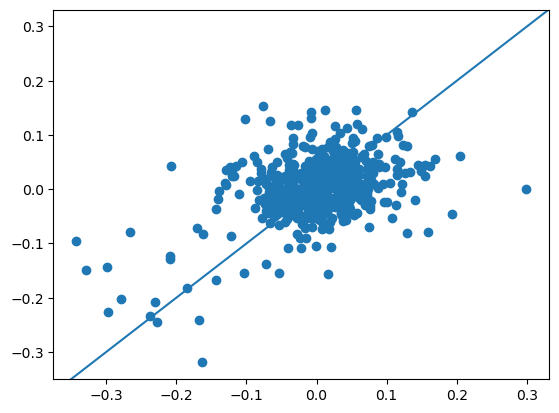

In [155]:
import matplotlib.pyplot as plt
plt.scatter(cv_pred["demean_yield"], cv_pred["demean_cv_prediction"])
plt.axline((-.3, -.3), (.3, .3))

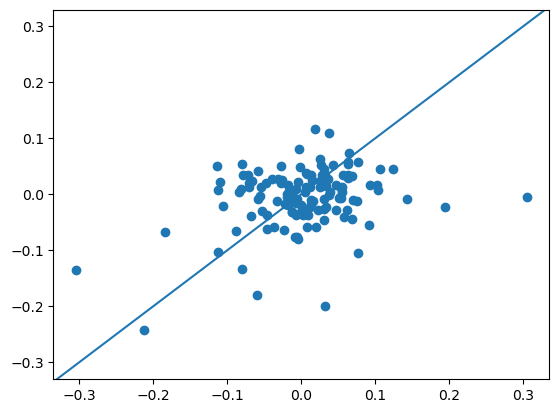

In [157]:
plt.scatter(test_pred["demean_yield"], test_pred["demean_prediction"])
plt.axline((-.3, -.3), (.3, .3))

In [31]:
# #########################################     SET PARAMS    #########################################
# file         = paramlist[0][0]
# hot_encode   = paramlist[0][1]



# f            = file.split(sep="_")
# satellite    = f[0]
# bands        = f[1].replace("bands-", "")
# country_code = f[2]
# points       = f[3].replace("k-points", "")
# num_features = f[4].replace("-features", "")
# yrs          = f[5].replace("yr-", "").split(sep="-")
# mns          = f[6].replace("mn-", "").split(sep="-")
# limit_months = str2bool(f[7].replace("lm-", ""))
# crop_mask    = str2bool(f[8].replace("cm-", ""))
# weighted_avg = str2bool(f[9].replace("wa-", ""))
# years        = range(int(yrs[0]), int(yrs[1])+1)
# month_range  = list(range(int(mns[0]), int(mns[1])+1))

# alphas = {'alpha': np.logspace(-8, 8, base = 10, num = 17)}
# kfold  = KFold()
# logo   = LeaveOneGroupOut()
# ridge  = Ridge()    

# #########################################     READ DATA    #########################################
# fn = f"{directory}/{file}"
# features = pd.read_feather(fn)

# drop_cols = ['district', 'year', 'yield_mt', "crop_perc"]

# if weighted_avg:
#     drop_cols.remove("crop_perc")
# else:
#     pass

# crop_yield = features.copy().loc[:, tuple(drop_cols)]

# #########################################     HOT ENCODE    ###########################################
# if hot_encode:
#     drop_cols.remove("district")
#     features = pd.get_dummies(features, columns=["district"], drop_first=False)
# else:
#     pass

# features['yield_mt'] = np.log10(features.yield_mt.to_numpy() + 1)

# #########################################     K-FOLD SPLIT    #########################################
# x_all = features.drop(drop_cols, axis = 1) 
# y_all = features.yield_mt
# x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, random_state=0)

# #########################################     K-FOLD CV    ###########################################

# ### GRID SEARCH - FINDING BEST REGULARIZATION PARAMETER
# kfold_ridge_reg = GridSearchCV(ridge, alphas, scoring = 'r2', cv = kfold)
# kfold_ridge_reg.fit(x_train, y_train)
# kfold_best_model = kfold_ridge_reg.best_estimator_
# ### PREDICT - PREDICTING WITH BEST HYPERPARAMETER
# kfold_val_predictions = cross_val_predict(kfold_best_model, X = x_train, y = y_train, cv = kfold)   
# y_pred_train_k = kfold_best_model.predict(x_train)
# y_pred_test_k  = kfold_best_model.predict(x_test)

# # #########################################     LOGO SPLIT   ###########################################
# #     x_train_g = features[features.year < max(features.year)].drop(drop_cols, axis=1)
# #     y_train_g = features[features.year < max(features.year)].yield_mt
# #     g_train_g = features[features.year < max(features.year)].year.ravel()

# #     x_test_g = features[features.year == max(features.year)].drop(drop_cols, axis=1)
# #     y_test_g = features[features.year == max(features.year)].yield_mt
# #     g_test_g = features[features.year == max(features.year)].year

# # #########################################     LOGO CV    ###########################################
# #     ### GRID SEARCH - FINDING BEST REGULARIZATION PARAMETER
# #     logo_ridge_reg = GridSearchCV(ridge, alphas, scoring='r2', cv=logo)
# #     logo_ridge_reg.fit(x_train_g, y_train_g, groups=g_train_g)
# #     logo_best_model = logo_ridge_reg.best_estimator_
# #     ### PREDICT - PREDICTING WITH BEST HYPERPARAMETER
# #     logo_val_predictions = cross_val_predict(logo_best_model, X=x_train_g, y=y_train_g, groups=g_train_g, cv=logo)   
# #     logo_train_pred = logo_best_model.predict(x_train_g)
# #     logo_test_pred  = logo_best_model.predict(x_test_g)

# #########################################     LOGO ITERATOR   ###########################################
# logo_val_results = []
# logo_train_results = []
# logo_test_results = []

# for year in features.year.unique():
# #########################################     LOGO SPLIT   ###########################################
#     x_train_g = features[features.year != year].drop(drop_cols, axis=1)
#     y_train_g = features[features.year != year].yield_mt.ravel()
#     g_train_g = features[features.year != year].year.ravel()
#     d_train_g = crop_yield[crop_yield.year != year].district.ravel()

#     x_test_g = features[features.year == year].drop(drop_cols, axis=1)
#     y_test_g = features[features.year == year].yield_mt.ravel()
#     g_test_g = features[features.year == year].year.ravel()
#     d_test_g = crop_yield[crop_yield.year == year].district.ravel()

# #########################################     LOGO CV   ###########################################
#     ### GRID SEARCH - FINDING BEST REGULARIZATION PARAMETER
#     logo_ridge_reg = GridSearchCV(ridge, alphas, scoring='r2', cv=logo)
#     logo_ridge_reg.fit(x_train_g, y_train_g, groups=g_train_g)
#     logo_best_model = logo_ridge_reg.best_estimator_
#     ### PREDICT - PREDICTING WITH BEST HYPERPARAMETER
#     logo_val_predictions = cross_val_predict(logo_best_model, X=x_train_g, y=y_train_g, groups=g_train_g, cv=logo) 
#     logo_train_pred = logo_best_model.predict(x_train_g)
#     logo_test_pred  = logo_best_model.predict(x_test_g)

# #########################################     LOGO RESULTS   ###########################################
#     val_results = {'year': g_train_g, 'district': d_train_g, 'split': 'val', 
#                    'observed': y_train_g, 'predicted': logo_val_predictions}

#     train_results = {'year': g_train_g, 'district': d_train_g,'split': 'train', 
#                      'observed': y_train_g, 'predicted': logo_train_pred}

#     test_results = {'year': g_test_g, 'district': d_test_g, 'split': 'test', 
#                     'observed': y_test_g, 'predicted': logo_test_pred}

#     logo_val_results.append(val_results)
#     logo_train_results.append(train_results)
#     logo_test_results.append(test_results)

# #########################################     EXPLODE RESULTS   ###########################################
# explode_cols = ['year', 'district', 'observed', 'predicted']
# val_df   = pd.DataFrame(logo_val_results  ).explode(explode_cols) 
# train_df = pd.DataFrame(logo_train_results).explode(explode_cols) 
# test_df  = pd.DataFrame(logo_test_results ).explode(explode_cols)

# group_cols = ['year', 'district', 'split']
# val_summary   =   val_df.groupby(group_cols, as_index=False).mean()
# train_summary = train_df.groupby(group_cols, as_index=False).mean()

# #########################################     DE-MEAN R2    #########################################    
# crop_yield["log_yield"] = np.log10(crop_yield.yield_mt.to_numpy() + 1)
# crop_yield["district_yield_mean"] = crop_yield.groupby('district')['log_yield'].transform('mean')
# crop_yield["demean_yield"] = crop_yield["log_yield"] - crop_yield["district_yield_mean"]

# crop_yield["kfold_prediction"] = np.maximum(kfold_best_model.predict(x_all), 0)
# crop_yield["kfold_district_prediction_mean"] = crop_yield.groupby('district')['kfold_prediction'].transform('mean')
# crop_yield["kfold_demean_prediction"] = crop_yield["kfold_prediction"] - crop_yield["kfold_district_prediction_mean"]

# join_cols = ['year', 'district']
# crop_yield = crop_yield.set_index(join_cols).join(test_df.set_index(join_cols)).reset_index()
# crop_yield["logo_district_prediction_mean"] = crop_yield.groupby('district')['predicted'].transform('mean')
# crop_yield["logo_demean_prediction"] = crop_yield["predicted"] - crop_yield["logo_district_prediction_mean"]

# # crop_yield["logo_prediction"] = np.maximum(logo_best_model.predict(x_all), 0)
# # crop_yield["logo_district_prediction_mean"] = crop_yield.groupby('district')['logo_prediction'].transform('mean')
# # crop_yield["logo_demean_prediction"] = crop_yield["logo_prediction"] - crop_yield["logo_district_prediction_mean"]

# #########################################     SAVE MODELS   #########################################  
# # model_fn_suffix = file.replace('_summary.feather', '')
# # k_model_fn  = f'kfold-cv_rr-model_{model_fn_suffix}_he-{hot_encode}.pkl'
# # logo_model_fn = f'logo-cv_rr-model_{model_fn_suffix}_he-{hot_encode}.pkl'

# # with open(here('models', k_model_fn),'wb') as f:
# #     pickle.dump(kfold_best_model, f)

# # with open(here('models', logo_model_fn),'wb') as f:
# #     pickle.dump(logo_best_model, f)

# #########################################     SAVE RESULTS    #########################################
# d = {
#     'country'     : country_code,
#     'satellite'   : satellite,
#     'bands'       : bands,
#     'num_features': num_features,
#     'points'      : points, 
#     'month_range' : f'{min(month_range)}-{max(month_range)}',

#     'limit_months': limit_months,
#     'crop_mask'   : crop_mask,
#     'weighted_avg': weighted_avg,
#     'hot_encode'  : hot_encode,

#     'kfold_total_n': len(x_all),
#     'kfold_train_n': len(x_train),
#     'kfold_test_n' : len(x_test),

#     'kfold_best_reg_param': list(kfold_ridge_reg.best_params_.values())[0],
#     'kfold_mean_of_val_R2': kfold_ridge_reg.best_score_,
#     'kfold_val_R2': r2_score(y_train, kfold_val_predictions),
#     'kfold_val_r' : pearsonr(kfold_val_predictions, y_train)[0],
#     'kfold_val_r2': pearsonr(kfold_val_predictions, y_train)[0] ** 2,

#     'kfold_train_R2': r2_score(y_train, y_pred_train_k),
#     'kfold_train_r' : pearsonr(y_pred_train_k, y_train)[0],
#     'kfold_train_r2': pearsonr(y_pred_train_k, y_train)[0] ** 2,

#     'kfold_test_R2': r2_score(y_test, y_pred_test_k),
#     'kfold_test_r' : pearsonr(y_pred_test_k, y_test)[0],
#     'kfold_test_r2': pearsonr(y_pred_test_k, y_test)[0] ** 2,

#     'logo_total_n': len(features),
#     'logo_train_n': len(train_df),
#     'logo_test_n' : len(test_df),    

#     'logo_best_reg_param': list(logo_ridge_reg.best_params_.values())[0],      
#     'logo_summary_val_R2': r2_score(val_summary.observed, val_summary.predicted),
#     'logo_summary_val_r' : pearsonr(val_summary.observed, val_summary.predicted)[0],

#     'logo_val_R2' : r2_score(val_df.observed, val_df.predicted),
#     'logo_val_r'  : pearsonr(val_df.predicted, val_df.observed)[0],
#     'logo_val_r2' : pearsonr(val_df.predicted, val_df.observed)[0] ** 2,

#     'logo_summary_train_R2': r2_score(train_summary.observed, train_summary.predicted),
#     'logo_summary_train_r' : pearsonr(train_summary.observed, train_summary.predicted)[0],

#     'logo_train_R2': r2_score(train_df.observed, train_df.predicted),
#     'logo_train_r' : pearsonr(train_df.predicted, train_df.observed)[0],
#     'logo_train_r2': pearsonr(train_df.predicted, train_df.observed)[0] ** 2,

#     'logo_test_R2': r2_score(test_df.observed, test_df.predicted),
#     'logo_test_r' : pearsonr(test_df.predicted, test_df.observed)[0],
#     'logo_test_r2': pearsonr(test_df.predicted, test_df.observed)[0] ** 2,

#     'kfold_demean_R2': r2_score(crop_yield["demean_yield"], crop_yield["kfold_demean_prediction"]),
#     'kfold_demean_r':  pearsonr(crop_yield["demean_yield"], crop_yield["kfold_demean_prediction"])[0],
#     'kfold_demean_r2': pearsonr(crop_yield["demean_yield"], crop_yield["kfold_demean_prediction"])[0] ** 2,

#     'logo_demean_R2': r2_score(crop_yield["demean_yield"], crop_yield["logo_demean_prediction"]),
#     'logo_demean_r':  pearsonr(crop_yield["demean_yield"], crop_yield["logo_demean_prediction"])[0],
#     'logo_demean_r2': pearsonr(crop_yield["demean_yield"], crop_yield["logo_demean_prediction"])[0] ** 2,

# }

In [8]:
# x = pd.DataFrame(d, index = [0])
# x